# Churn Prediction - Telecom Case
Author: Daniel Grzebyk

Date: 1.07.2022

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder

from scipy.stats import chi2, chi2_contingency

from classification_utils import chi_test

In [2]:
# TODO: Distinguish between nominal and orindal variables!

## Loading the data

In [3]:
df = pd.read_csv("data/telecom/data.csv")
var_df = pd.read_csv("data/telecom/variables-definition.csv")

## Exploratory Data Analysis (EDA)
Research Question: Why customers leave the company?

Hypothesis to be verified:
- the services are too expensive - if yes, then lower income households would leave more frequently, as they are more price-sensitive
- the services are not required - if yes, few calls, low data usage, etc.
- low quality of service - many calls failed due to network issues
- geography: maybe in some geographical areas (lower network coverage or income)
- are household with children more loyal customers?

Relevant Observations:
- Data Structure: every row is a customer / household
- Problem: binary classification problem: predict whether a customer will stay with the telecom company or leave
- Label: churn - the customer will leave [yes / no]

Interesting features
- Failed calls might indicate issues with the quality of service. What % of all calls fails, and how does it influence customer loyalty?
- Time spent calling customer service, happy customers rarely call.

Features not relevant for predicting churn:
- Number and minutes of unanswered and received calls
- Whether calls are wireless or not
- Network traffic, whether call is peak or off-peak
- The number of call participants
- Whether calls are incoming or outbound
- Distinction between voice and data calls

### Loyalty
The distribution is right-skewed, peak around the 12th month might indicate past sale or a marketing campaign. The longest staying customer is with the company for 5 years. 

<AxesSubplot:xlabel='months', ylabel='Count'>

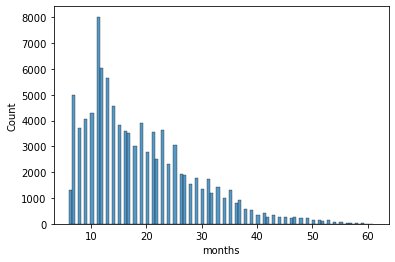

In [4]:
sns.histplot(df['months'])

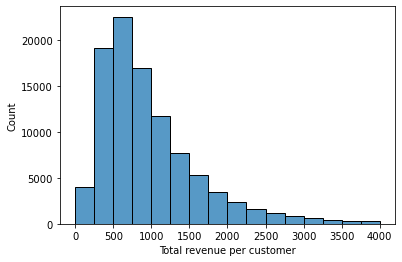

In [5]:
sns.histplot(df['totrev'], binrange=(0, 4000), binwidth=250)
plt.xlabel("Total revenue per customer")
plt.show()

### Company Revenue
As customer requirements are covered by multiple products, in order to check which customers significantly changed their consumption it is the easiest to look at the revenue. It can be seen that around 5% of all customers reduced their spending by at least 50% with respect to the 3 month mean. These customers might be the potential leavers.

After identifying who the potential leavers might be, it will be checked what % of revenue they bring to the company. E.g. suddent outflow of high-revenue clients could be a source of a major concern.

In [6]:
rapid_reduction_rate = round(len(df['change_rev'].loc[df['change_rev'] < -50]) / len(df), 2)
rapid_reduction_rate

0.05

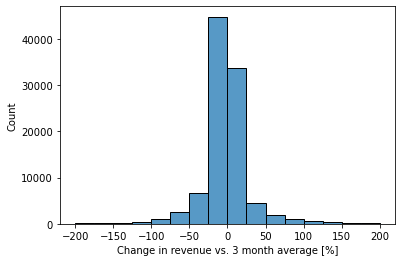

In [7]:
sns.histplot(df['change_rev'], binrange=(-200, 200), binwidth=25)
plt.xlabel("Change in revenue vs. 3 month average [%]")
plt.show()

Customers who use more than they declared in their plan often bear additional costs. Are these costs the reason why they change the service provider? Probably not, as they are usually less than 10% of the overall costs.

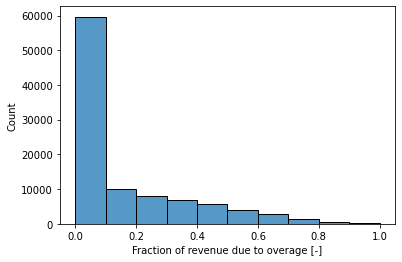

In [8]:
df['overrev_ratio'] = df['ovrrev_Mean'] / df['rev_Mean']
sns.histplot(df['overrev_ratio'], binrange=(0, 1), binwidth=0.1)
plt.xlabel("Fraction of revenue due to overage [-]")
plt.show()

Clearly, there are very few customers who pay for the service and not use it. Therefore, rapid drop of demand might be correlated with churn.

<AxesSubplot:xlabel='actsubs_ratio', ylabel='Count'>

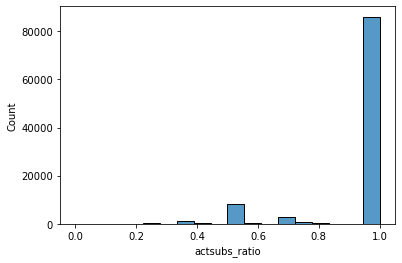

In [9]:
df['actsubs_ratio'] = df['actvsubs'] / df['uniqsubs']
sns.histplot(df['actsubs_ratio'])

### Customers social status
Client income is a categorical variable, but no information about the brackets for each class were provided. It is assumed that income will be the most influencial of all status-related features including also: size of dwelling, credit card information, number of cars, etc. Strong correlations are expected between these features, and perhaps some of them could be removed.

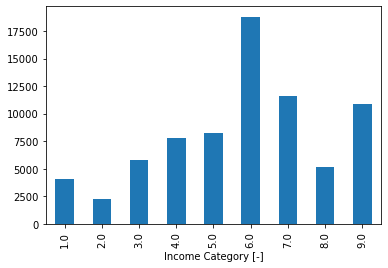

In [10]:
df['income'].value_counts().sort_index().plot(kind='bar')
plt.xlabel("Income Category [-]")
plt.show()

Chi test is used to check whether there is correlation between income and other features related to social status. As expected, all features in this category are correlated which means they not introduce new information to the dataset and therefore are removed. 

In [11]:
maybe_dependent_cols = ['crclscod', 'asl_flag', 'prizm_social_one', 'ownrent', 'lor', 'dwlltype', 'dwllsize', 'numbcars', 
                        'HHstatin', 'forgntvl', 'creditcd']
correlated_features, uncorrelated_features, results_dict = chi_test(df, maybe_dependent_cols, df['income'])

In [12]:
correlated_features

['crclscod',
 'asl_flag',
 'prizm_social_one',
 'ownrent',
 'lor',
 'dwlltype',
 'dwllsize',
 'numbcars',
 'HHstatin',
 'forgntvl',
 'creditcd']

In [13]:
df.drop(columns=correlated_features, inplace=True)

### Household information
How many households have children, and are households with children more loyal customers? The initial hypothesis is the parents of young children are too busy to make changes in telecom providers, but this tendency is expected to disappear as children are older.

<AxesSubplot:xlabel='totmrc_Mean', ylabel='Count'>

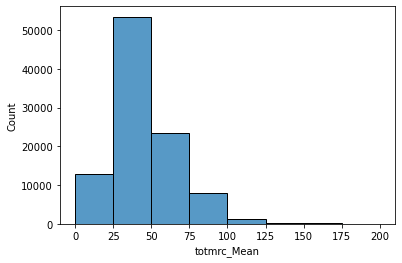

In [14]:
sns.histplot(df['totmrc_Mean'], binrange=(0, 200), binwidth=25)

### Quality of service
Median time of a call with customer service is 2 min which might mean the issues are resolved relatively quickly.

In [15]:
(df['ccrndmou_Mean'] / df['custcare_Mean']).median()

2.000000003

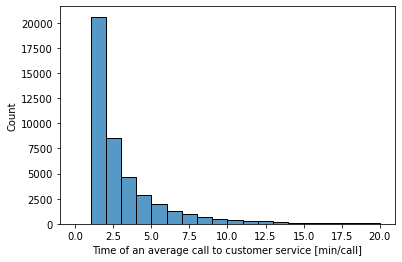

In [16]:
sns.histplot(df['ccrndmou_Mean'] / df['custcare_Mean'], binrange=(0, 20), binwidth=1)
plt.xlabel("Time of an average call to customer service [min/call]")
plt.show()

High percentage of failed calls or old equipment could indicate low quality of service and influence customer churn. It does not matter whether headset is refurbished or new, churn value is evenly distributed. 

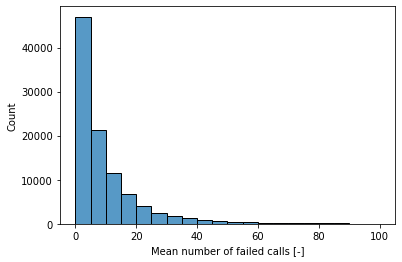

In [17]:
failed_calls = df['drop_vce_Mean'] + df['drop_dat_Mean'] + df['blck_vce_Mean'] + df['blck_dat_Mean']
sns.histplot(failed_calls, binrange=(0, 100), binwidth=5)
plt.xlabel("Mean number of failed calls [-]")
plt.show()

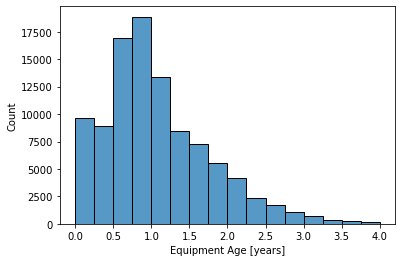

In [18]:
sns.histplot(df['eqpdays'] / 365, binrange=(0, 4), binwidth=0.25)
plt.xlabel("Equipment Age [years]")
plt.show()

### Other
Churn is more or less equally distributed across all areas of operation. Non-uniform distribution could undicate e.g. new strong competition. 

In [19]:
df['churn'].value_counts()

0    50438
1    49562
Name: churn, dtype: int64

## Feature Engineering

In [20]:
features_eliminated = ['Customer_ID', 'peak_vce_Mean', 'peak_dat_Mean', 'mou_peav_Mean', 'mou_pead_Mean', 'opk_vce_Mean',
                       'opk_dat_Mean', 'mou_opkv_Mean', 'mou_opkd_Mean', 'owylis_vce_Mean', 'mouowylisv_Mean',
                       'iwylis_vce_Mean', 'mouiwylisv_Mean', 'inonemin_Mean', 'threeway_Mean', 'mou_cvce_Mean', 
                       'mou_cdat_Mean', 'mou_rvce_Mean', 'drop_blk_Mean', 'attempt_Mean', 'complete_Mean', 'callfwdv_Mean',
                       'callwait_Mean', 'unan_vce_Mean', 'unan_dat_Mean', 'recv_vce_Mean', 'recv_sms_Mean',
                       'cc_mou_Mean', 'plcd_vce_Mean', 'plcd_dat_Mean', 'comp_vce_Mean', 'comp_dat_Mean', 'roam_Mean',
                       'ethnic']

# df.drop(columns=features_eliminated, inplace=True)
# Knowing number of calls and their mean time, average time per call can be calculated

In [21]:
df.shape

(100000, 91)

In [22]:
df['failed_calls'] = df['drop_vce_Mean'] + df['drop_dat_Mean'] + df['blck_vce_Mean'] + df['blck_dat_Mean']
df['actsubs_ratio'] = df['actvsubs'] / df['uniqsubs']
df['custcall_time_Mean'] = df['ccrndmou_Mean'] / df['custcare_Mean']

df.drop(columns=['drop_vce_Mean', 'drop_dat_Mean', 'blck_vce_Mean', 'blck_dat_Mean', 'actvsubs', 'uniqsubs',
                 'ccrndmou_Mean', 'custcare_Mean'], inplace=True)

## Data Preprocessing

In [23]:
X = df.drop(columns=['churn']).copy()
y = df['churn'].copy()

### Looking for duplicates

In [24]:
X.duplicated().sum()

0

### Dropping NaNs

In [25]:
# Count NaNs
nans_per_feature = X.isna().sum()
nans_per_feature[nans_per_feature > 30000]  # Is one of the dropped features crucial?

custcall_time_Mean    55692
dtype: int64

In [26]:
cols_to_drop = list(nans_per_feature[nans_per_feature > 30000].index)  # drop features which have more than 20% NaNs
X.drop(columns=cols_to_drop, inplace=True)
print("Dropping:", cols_to_drop)

print("Before dropping rows with NaNs:", X.shape)
X.dropna(inplace=True)
y = y.loc[X.index]
print("After dropping rows with NaNs:", X.shape)

Dropping: ['custcall_time_Mean']
Before dropping rows with NaNs: (100000, 83)
After dropping rows with NaNs: (63338, 83)


TODO: Should binary columns be treated as categorical columns?

In [41]:
num_features = X.select_dtypes(include='number').columns
cat_features = X.select_dtypes(include='object').columns

### Looking for correlations
#### Categorical Features
Again, chi-test is used on categorical features to check if they are correlated with our label (churn). This time the _uncorrelated_ features are dropped, because correlation implies potential influence on the label and predictive power of the model. 

In [49]:
def find_boolean_features(X):
    """
    Args:
        X (pd.DataFrame) - 
    Returns:
        bool_features (list): column names containing maximum 2 unique values
    """
    bool_features = []
    for col in X.columns:
        if len(X[col].unique()) <= 2:
            bool_features.append(col)
    return bool_features

In [61]:
bool_features = find_boolean_features(X[num_features])
# [cat_features.append(x) for x in bool_features]

In [29]:
correlated_features, uncorrelated_features, results_dict = chi_test(X, cat_features, y)

In [30]:
uncorrelated_features

['new_cell', 'infobase', 'kid6_10', 'kid11_15']

In [31]:
X.drop(columns=uncorrelated_features, inplace=True)

#### Numerical features
Continous numerical features are also investigated looking for correlations.

TODO: Identifying binary features

In [138]:
df[num_features].var().sort_values(ascending=False).tail(10)

datovr_Mean      9.775199
income           4.761698
da_Mean          4.742025
recv_sms_Mean    4.525926
adults           2.110684
threeway_Mean    1.192684
callfwdv_Mean    0.299724
unan_dat_Mean    0.246979
truck            0.153169
actsubs_ratio    0.029634
dtype: float64

<AxesSubplot:>

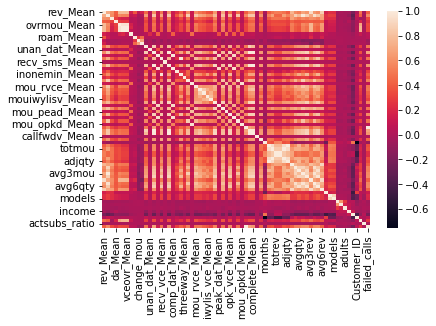

In [33]:
corr = df[num_features].corr()
sns.heatmap(corr)

In [34]:
# Create correlation matrix
corr_matrix = X.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.5
correlated_features = [column for column in upper.columns if any(upper[column] > 0.5)]
print("Correlated features:", correlated_features)

# Drop features 
X.drop(correlated_features, axis=1, inplace=True)

Correlated features: ['mou_Mean', 'totmrc_Mean', 'ovrmou_Mean', 'ovrrev_Mean', 'vceovr_Mean', 'change_rev', 'unan_vce_Mean', 'plcd_vce_Mean', 'recv_vce_Mean', 'comp_vce_Mean', 'comp_dat_Mean', 'inonemin_Mean', 'mou_cvce_Mean', 'mou_cdat_Mean', 'mou_rvce_Mean', 'owylis_vce_Mean', 'mouowylisv_Mean', 'iwylis_vce_Mean', 'mouiwylisv_Mean', 'peak_vce_Mean', 'peak_dat_Mean', 'mou_peav_Mean', 'mou_pead_Mean', 'opk_vce_Mean', 'opk_dat_Mean', 'mou_opkv_Mean', 'mou_opkd_Mean', 'drop_blk_Mean', 'attempt_Mean', 'complete_Mean', 'callwait_Mean', 'totcalls', 'totmou', 'totrev', 'adjrev', 'adjmou', 'adjqty', 'avgrev', 'avgmou', 'avgqty', 'avg3mou', 'avg3qty', 'avg3rev', 'avg6mou', 'avg6qty', 'avg6rev', 'phones', 'models', 'rv', 'Customer_ID', 'overrev_ratio', 'failed_calls']


<AxesSubplot:>

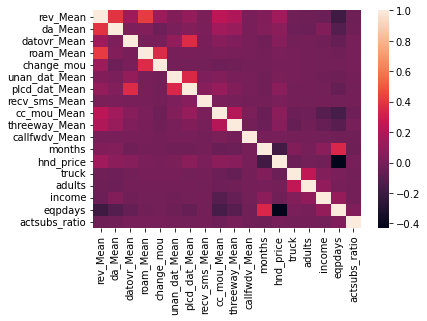

In [58]:
sns.heatmap(X[num_features].corr())

### Looking for class imbalance

In [36]:
y.value_counts()

0    33043
1    30295
Name: churn, dtype: int64

### Identifying numerical, categorical, text features

In [56]:
X.select_dtypes(include='number').columns

Index(['rev_Mean', 'mou_Mean', 'totmrc_Mean', 'da_Mean', 'ovrmou_Mean',
       'ovrrev_Mean', 'vceovr_Mean', 'datovr_Mean', 'roam_Mean', 'change_mou',
       'change_rev', 'unan_vce_Mean', 'unan_dat_Mean', 'plcd_vce_Mean',
       'plcd_dat_Mean', 'recv_vce_Mean', 'recv_sms_Mean', 'comp_vce_Mean',
       'comp_dat_Mean', 'cc_mou_Mean', 'inonemin_Mean', 'threeway_Mean',
       'mou_cvce_Mean', 'mou_cdat_Mean', 'mou_rvce_Mean', 'owylis_vce_Mean',
       'mouowylisv_Mean', 'iwylis_vce_Mean', 'mouiwylisv_Mean',
       'peak_vce_Mean', 'peak_dat_Mean', 'mou_peav_Mean', 'mou_pead_Mean',
       'opk_vce_Mean', 'opk_dat_Mean', 'mou_opkv_Mean', 'mou_opkd_Mean',
       'drop_blk_Mean', 'attempt_Mean', 'complete_Mean', 'callfwdv_Mean',
       'callwait_Mean', 'months', 'totcalls', 'totmou', 'totrev', 'adjrev',
       'adjmou', 'adjqty', 'avgrev', 'avgmou', 'avgqty', 'avg3mou', 'avg3qty',
       'avg3rev', 'avg6mou', 'avg6qty', 'avg6rev', 'hnd_price', 'phones',
       'models', 'truck', 'rv', 'adul

In [57]:
X.select_dtypes(include='object').columns

Index(['new_cell', 'area', 'dualband', 'refurb_new', 'hnd_webcap', 'marital',
       'infobase', 'ethnic', 'kid0_2', 'kid3_5', 'kid6_10', 'kid11_15',
       'kid16_17'],
      dtype='object')

In [58]:
X.select_dtypes(include='category').columns

Index([], dtype='object')

In [59]:
num_features = X.select_dtypes(include='number').columns
cat_features = X.select_dtypes(include='object').columns

In [41]:
len(num_features), len(cat_features)

(18, 9)

## Predicting churn

### Splitting the data

In [122]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

### Training the model

In [123]:
# X_train = X_train[num_features]
# X_val = X_val[num_features]

In [124]:
X_train.shape

(50670, 27)

In [125]:
from sklearn.model_selection import GridSearchCV

https://towardsdatascience.com/pipelines-automated-machine-learning-with-hyperparameter-tuning-part-1-b9c06a99d3c3

In [129]:
%%time
# I did not identify text features
ct = make_column_transformer((MinMaxScaler(), num_features),
                             (OneHotEncoder(handle_unknown='ignore'), cat_features),
                             n_jobs=-1,
                             verbose=False)

pipeline = Pipeline(
    steps=[("preprocessor", ct), ("regressor", RandomForestClassifier(n_estimators=10, max_features=3, random_state=42,
                                                                      min_samples_leaf=1))]
)

# param_grid = {
#     "regressor__max_features": [5, 10, 15, 20],
#     "regressor__max_depth": [5, 10, 15, 20]
# }

# search = GridSearchCV(pipeline, param_grid, n_jobs=-1, cv=3, verbose=3)
# search.fit(X_train, y_train)

# print("Best parameter (CV score=%0.3f):" % search.best_score_)
# print(search.best_params_)

# max_depth is the how many splits deep you want each tree to go
# min_samples_leaf is how many observations are at the end of a branch before I forbid the tree from splitting further.
    
# Training the model
pipeline.fit(X_train, y_train)

Wall time: 887 ms


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('minmaxscaler',
                                                  MinMaxScaler(),
                                                  Index(['rev_Mean', 'da_Mean', 'datovr_Mean', 'roam_Mean', 'change_mou',
       'unan_dat_Mean', 'plcd_dat_Mean', 'recv_sms_Mean', 'cc_mou_Mean',
       'threeway_Mean', 'callfwdv_Mean', 'months', 'hnd_price', 'truck',
       'adults', 'income', 'eqpdays', 'actsubs_ratio'],
      dtype='object')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['area', 'dualband', 'refurb_new', 'hnd_webcap', 'marital', 'ethnic',
       'kid0_2', 'kid3_5', 'kid16_17'],
      dtype='object'))])),
                ('regressor',
                 RandomForestClassifier(max_features=3, n_est

In [130]:
# Train Inference
y_pred = pipeline.predict(X_train)
y_val_pred = pipeline.predict(X_val)

In [131]:
# Train metric
train_acc = accuracy_score(y_train, y_pred)
train_prec = precision_score(y_train, y_pred)
train_recall = recall_score(y_train, y_pred)
print("Train Accuracy:", train_acc.round(2))
print("Train Precision:", train_prec.round(2))
print("Train Recall:", train_recall.round(2))

# Val metric
val_acc = accuracy_score(y_val, y_val_pred)
val_prec = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)
print("\nValidation Accuracy:", val_acc.round(2))
print("Validation Precision:", val_prec.round(2))
print("Validation Recall:", val_recall.round(2))

Train Accuracy: 0.99
Train Precision: 1.0
Train Recall: 0.97

Validation Accuracy: 0.57
Validation Precision: 0.57
Validation Recall: 0.43


## Error Analysis / Postprocessing

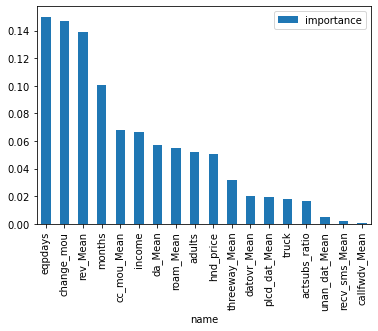

In [56]:
feature_names = X_train.columns
feature_importances = pipeline.steps[1][1].feature_importances_

importance_df = pd.DataFrame({"name":feature_names, "importance":feature_importances})
importance_df = importance_df.sort_values(by='importance', ascending=False)
importance_df.plot(kind='bar', x='name')
plt.show()

In [ ]:
importance_df
# equipment age
# minutes of calls
# 